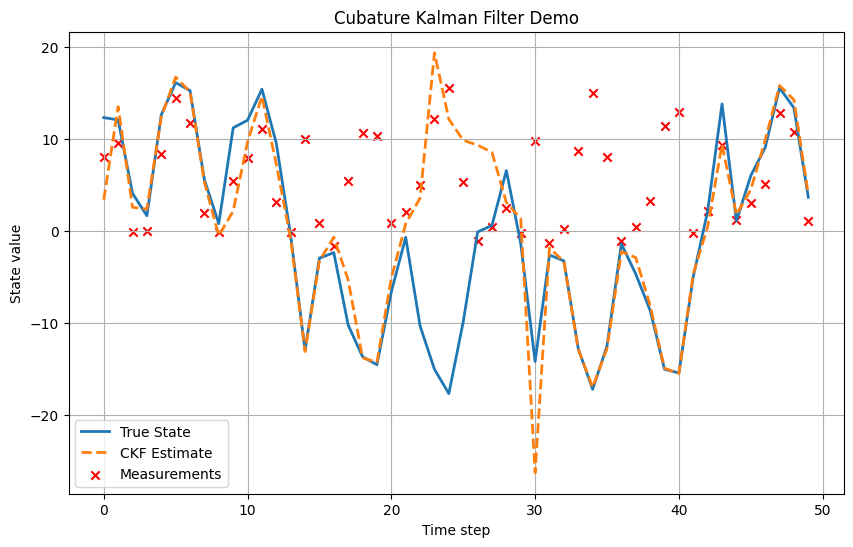

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, inv

# -----------------------------
# Define process and measurement models
# -----------------------------
def process_model(x, k):
    """
    Nonlinear process model.
    In this example, the state evolves as:
      x[k+1] = 0.5*x[k] + 25*x[k]/(1 + x[k]**2) + 8*cos(1.2*k) + process noise
    Input:
      x - state vector (np.array of shape (n,))
      k - discrete time index (integer)
    Returns:
      f(x) as a numpy array of shape (n,)
    """
    # For a one-dimensional state, x is an array of shape (1,)
    val = 0.5 * x[0] + 25 * x[0] / (1 + x[0]**2) + 8 * np.cos(1.2 * k)
    return np.array([val])

def measurement_model(x):
    """
    Nonlinear measurement model.
    In this example:
      z = x^2/20 + measurement noise
    Input:
      x - state vector (np.array of shape (n,))
    Returns:
      measurement as a scalar.
    """
    return (x[0]**2) / 20.0

# -----------------------------
# Cubature Kalman Filter functions
# -----------------------------
def ckf_predict(x, P, k, Q):
    """
    CKF prediction step.
    Input:
      x - current state estimate (n-dimensional numpy array)
      P - current error covariance (n x n numpy array)
      k - current time index (integer)
      Q - process noise covariance (n x n numpy array)
    Returns:
      x_pred - predicted state estimate
      P_pred - predicted error covariance
    """
    n = x.shape[0]  # state dimension
    S = cholesky(P)  # lower triangular square-root factor of P
    sqrt_n = np.sqrt(n)

    # Generate 2*n cubature points: x ± sqrt(n) * column_i(S)
    cub_points = np.zeros((2*n, n))
    for i in range(n):
        cub_points[i]   = x + sqrt_n * S[:, i]
        cub_points[i+n] = x - sqrt_n * S[:, i]

    # Propagate cubature points through the process model
    X = np.zeros((2*n, n))
    for i in range(2*n):
        X[i] = process_model(cub_points[i], k)

    # Compute predicted state as the average of propagated points
    x_pred = np.mean(X, axis=0)

    # Compute predicted covariance
    P_pred = np.zeros((n, n))
    for i in range(2*n):
        diff = (X[i] - x_pred).reshape(-1, 1)
        P_pred += diff @ diff.T
    P_pred /= (2*n)
    P_pred += Q
    return x_pred, P_pred

def ckf_update(x_pred, P_pred, z, R):
    """
    CKF measurement update step.
    Input:
      x_pred - predicted state estimate (n-dimensional numpy array)
      P_pred - predicted covariance (n x n numpy array)
      z - measurement (scalar)
      R - measurement noise variance (scalar)
    Returns:
      x_upd - updated state estimate
      P_upd - updated error covariance
    """
    n = x_pred.shape[0]
    S = cholesky(P_pred)
    sqrt_n = np.sqrt(n)

    # Generate cubature points for the measurement update
    cub_points = np.zeros((2*n, n))
    for i in range(n):
        cub_points[i]   = x_pred + sqrt_n * S[:, i]
        cub_points[i+n] = x_pred - sqrt_n * S[:, i]

    # Propagate cubature points through the measurement model
    Z = np.zeros((2*n, 1))
    for i in range(2*n):
        Z[i] = measurement_model(cub_points[i])

    # Compute predicted measurement and innovation covariance
    z_pred = np.mean(Z)
    Pzz = 0.0
    Pxz = np.zeros((n, 1))
    for i in range(2*n):
        dz = Z[i] - z_pred
        Pzz += dz * dz
        Pxz += (cub_points[i] - x_pred).reshape(-1, 1) * dz
    Pzz /= (2*n)
    Pxz /= (2*n)
    Pzz += R

    # Kalman gain and update
    K = Pxz / Pzz
    x_upd = x_pred + K * (z - z_pred)
    P_upd = P_pred - K * Pzz * K.T
    return x_upd, P_upd

# -----------------------------
# Simulation parameters and initialization
# -----------------------------
T = 50  # total time steps
n = 1   # state dimension (1D system)

# True initial state and initial estimates
x0_true = np.array([0.1])
x0_est  = np.array([0.0])
P0 = np.array([[1.0]])

# Noise covariances
Q = np.array([[1.0]])  # process noise covariance (1x1)
R = 1.0              # measurement noise variance

# Arrays to store simulation results
true_states = np.zeros((T, n))
est_states  = np.zeros((T, n))
measurements = np.zeros(T)

# Initialize state and covariance for simulation and filter
x_true = x0_true.copy()
x_est  = x0_est.copy()
P = P0.copy()

np.random.seed(0)  # for reproducibility

# -----------------------------
# Run the simulation and CKF
# -----------------------------
for k in range(T):
    # ----- True state evolution -----
    # Process noise sampled from N(0,Q)
    w = np.random.multivariate_normal(np.zeros(n), Q)
    x_true = process_model(x_true, k) + w
    true_states[k] = x_true

    # ----- Measurement -----
    # Measurement noise sampled from N(0,R)
    v = np.random.normal(0, np.sqrt(R))
    z = measurement_model(x_true) + v
    measurements[k] = z

    # ----- CKF Prediction -----
    x_pred, P_pred = ckf_predict(x_est, P, k, Q)

    # ----- CKF Update -----
    x_est, P = ckf_update(x_pred, P_pred, z, R)
    est_states[k] = x_est

# -----------------------------
# Plot the results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(true_states, label='True State', linewidth=2)
plt.plot(est_states, label='CKF Estimate', linestyle='--', linewidth=2)
plt.scatter(np.arange(T), measurements, color='red', label='Measurements', marker='x')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.title('Cubature Kalman Filter Demo')
plt.legend()
plt.grid(True)
plt.show()